In [72]:
# import all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import h5py

! pip install xlrd

In [73]:
all_df = pd.read_excel('trainDataset.xls', index_col=False)

all_df = all_df.drop('ID', axis=1)

invalid = []

for index, row in all_df.iterrows():
    for key in row.keys():
        if row[key] == 999:
            invalid.append(index)

all_df = all_df.drop(index = invalid)
all_df = all_df.drop('pCR (outcome)', axis=1)

all_df

,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,144.000000,41.0,0,0,0,1,3,3,1,1,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,142.000000,39.0,1,1,0,0,3,3,1,1,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,135.000000,31.0,0,0,0,1,2,1,1,0,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,12.000000,35.0,0,0,0,1,3,3,1,1,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,109.000000,61.0,1,0,0,0,2,1,1,0,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,49.250000,46.1,0,0,0,1,3,3,1,1,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,48.500000,53.3,0,0,0,1,2,1,1,0,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,47.500000,68.8,1,0,0,0,3,3,1,1,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,46.916667,46.0,1,0,0,0,2,1,1,1,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


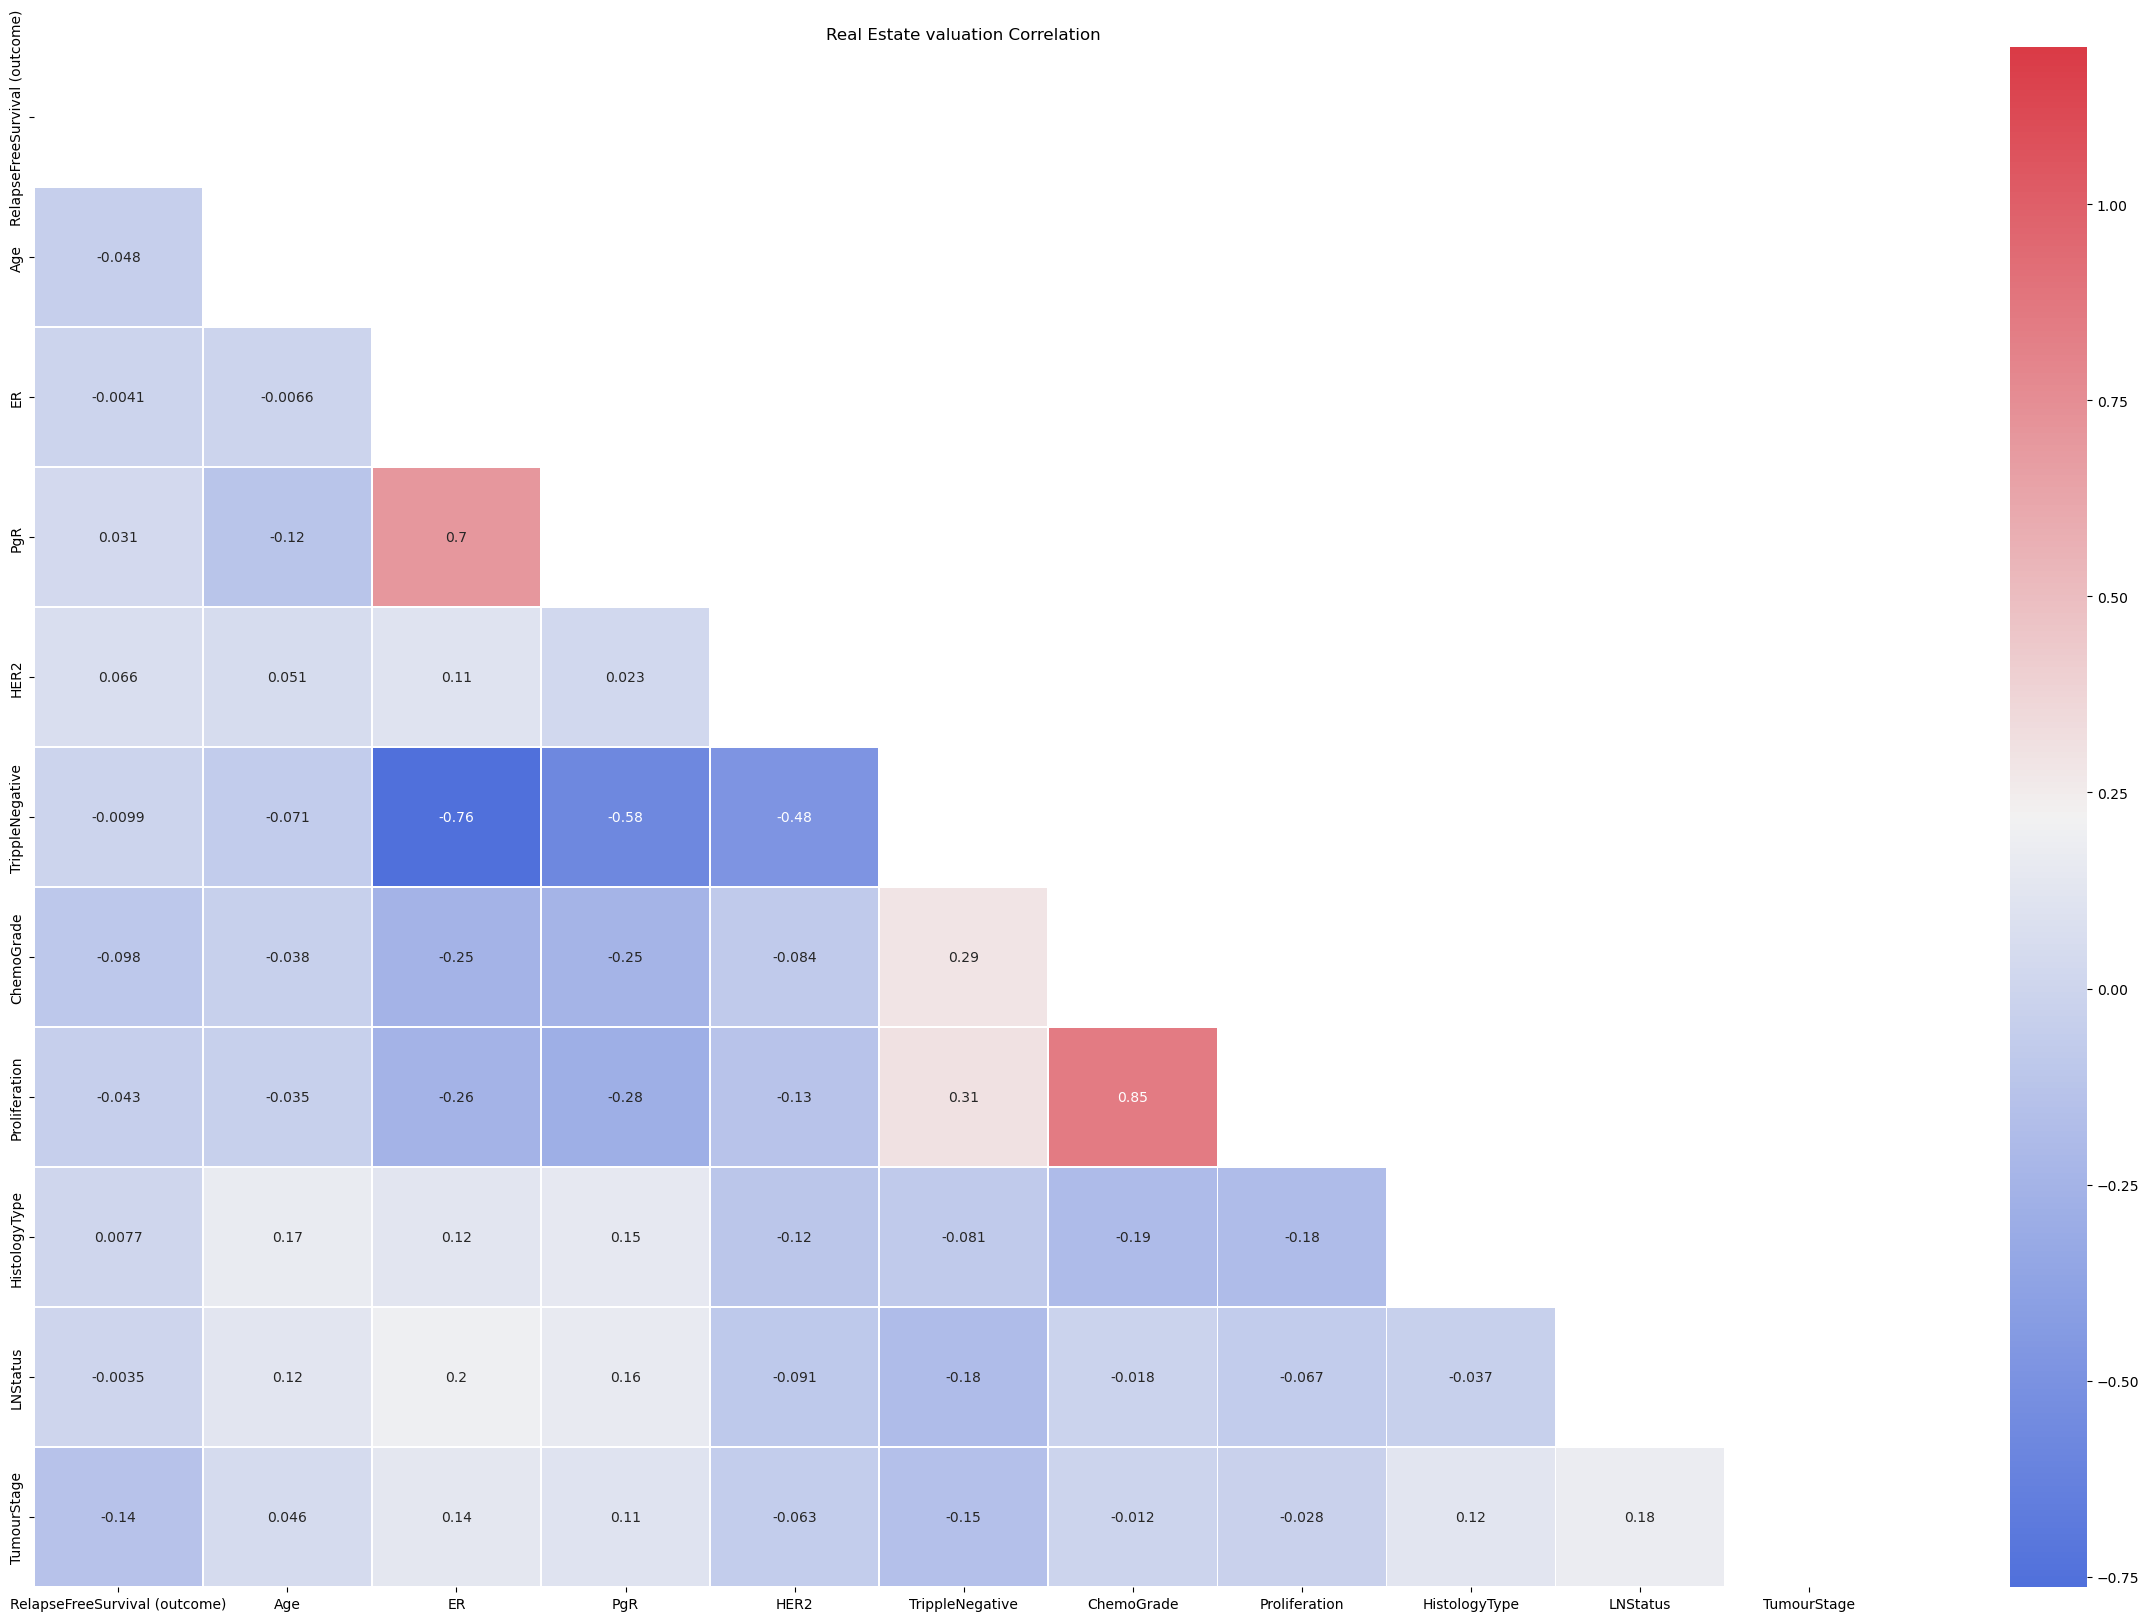

In [74]:
corrMatt = all_df.iloc[:,0:11].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

wholeCorrMatt = all_df.corr()

weak = []

for index, row in wholeCorrMatt.iterrows():
    if abs(row['RelapseFreeSurvival (outcome)']) < 0.05:
        weak.append(index)

all_df = all_df.drop(columns=weak,axis=1)

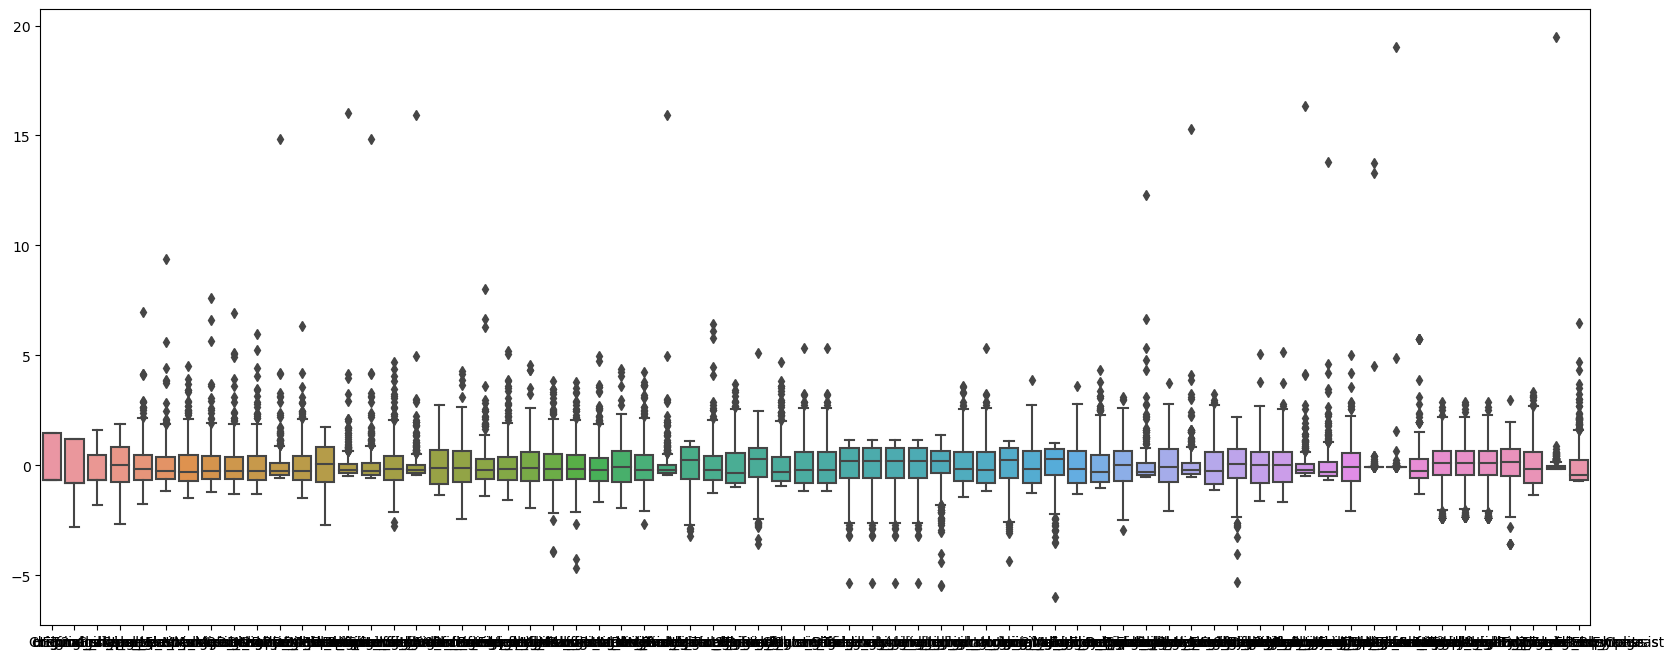

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_df.iloc[:,1:] = scaler.fit_transform(all_df.iloc[:,1:])
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=all_df.iloc[:,1:],ax=ax)

In [76]:
from collections import Counter

def detect_outliers(df, n, features):
    '''
    这种方法允许输入是nan值
    df: 表示dataFrame类型
    n: 表示被多少个特征判定为异常点才输出
    features: 表示检测异常点的特征
    '''
    # 用来保存异常点的索引
    outlier_indices = []
    for col in features:
        ## 第1个四分位点
        Q1 = np.percentile(df[col], 25)
        ## 第3个四分位点
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1 
        
        lower_limit = Q1 - 1.5 * IQR  # 下界
        upper_limit = Q3 + 1.5 * IQR  # 上届
        
        outlier_list_col = df[(df[col]<lower_limit) | (df[col] > upper_limit)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    # 如果被n个特征判定为异常点，则输出
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

rows = detect_outliers(all_df,1,all_df.iloc[:,1:])

all_df = all_df.drop(index=rows, axis=0)

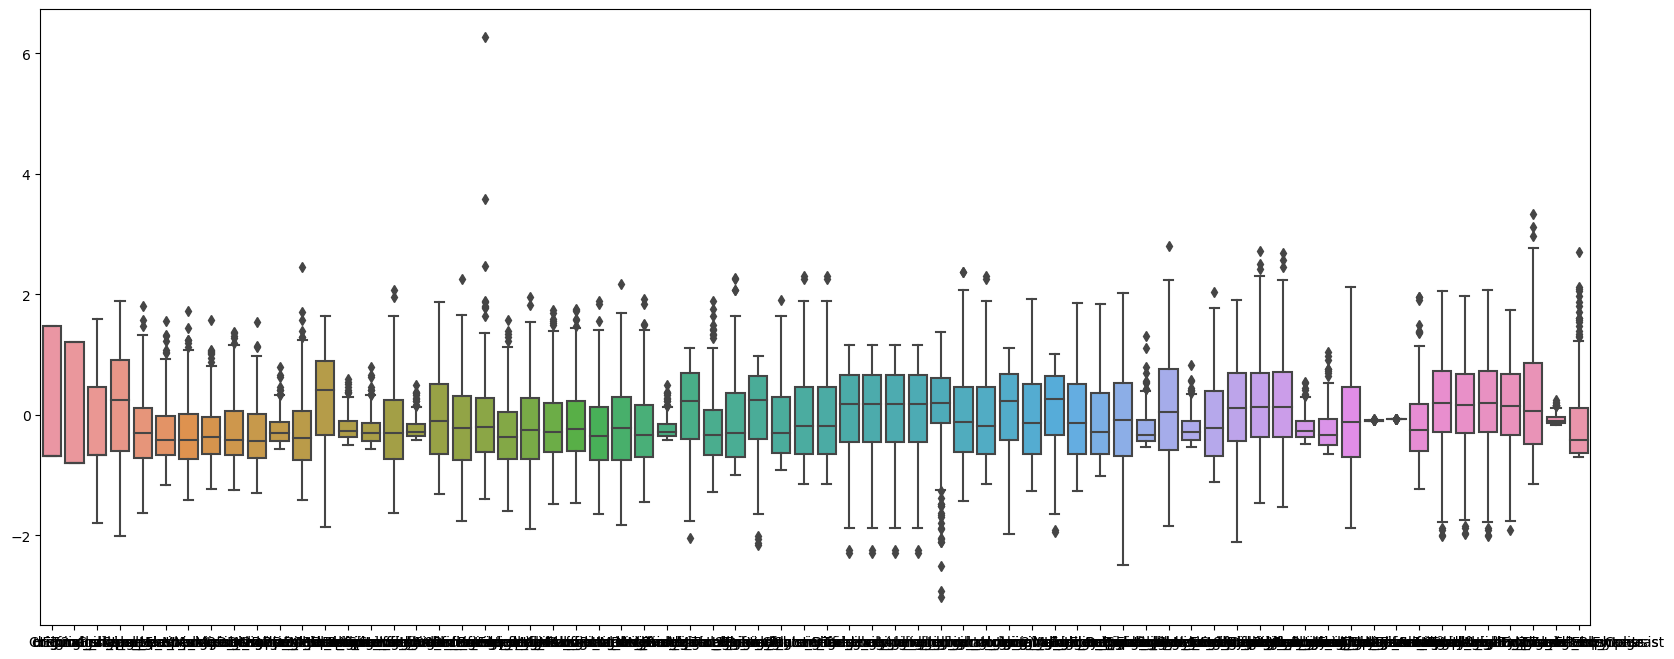

In [77]:
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=all_df.iloc[:,1:],ax=ax)

### SVM

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

features = all_df.iloc[:,1:]
rFS = all_df["RelapseFreeSurvival (outcome)"]
svm = SVR(kernel="rbf", gamma='auto')

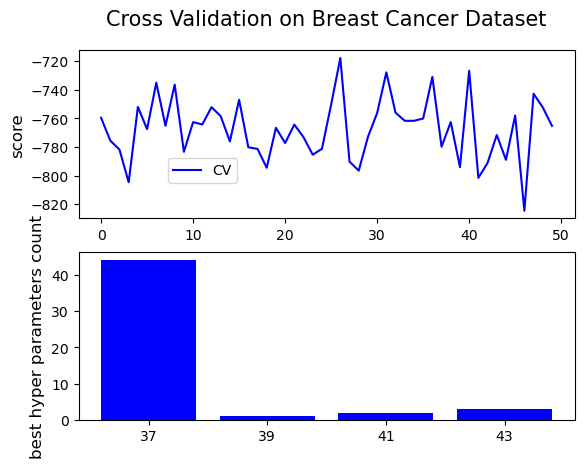

In [79]:
NUM_TRIALS = 50
X = features
y = rFS

# Set up possible values of parameters to optimize over
p_grid = {"C": [37,39,41,43]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring='neg_mean_squared_error')
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-37)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[37,39,41,43])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

In [80]:
svm = SVR(C = 37,kernel="rbf", gamma='auto')
cv_error_array = cross_val_score(svm, features, rFS,scoring='neg_mean_squared_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation MSE score for this method is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this method is 918.42


### Random Forest

In [81]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = all_df.iloc[:,1:]
RFS = all_df["RelapseFreeSurvival (outcome)"]

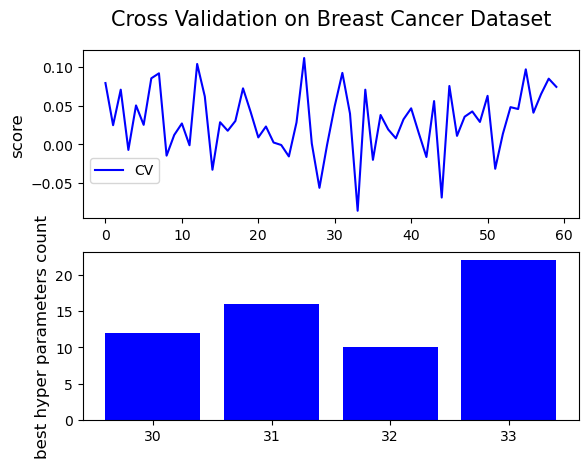

In [82]:
NUM_TRIALS = 60
X = features
y = RFS

rf_model = RandomForestRegressor(random_state=66)
n_estimators_grid = {"n_estimators": [30,31,32,33]}
scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    reg = GridSearchCV(estimator=rf_model, param_grid=n_estimators_grid, cv=cv)
    reg.fit(X,y)
    scores[i] = reg.best_score_
    params.append(reg.best_params_)

best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int(i["n_estimators"]-30)] = params.count(i)

# Plot scores on each trial for CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[30,31,32,33])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()


In [83]:
rf_model = RandomForestRegressor(n_estimators=33, random_state=66)
X_train, X_test, y_train, y_test = train_test_split(features, RFS, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)

from sklearn import metrics
print('MSE: {}'.format(metrics.mean_squared_error(pred,y_test)))

平均绝对误差（回归树二乘偏差均值）:799.8819483686909
均方误差MSE（回归树二乘偏差均值）:24.696386946386948
解释方差分:-5.859696664049204
R2得分:-5.873208560894542


### Decision Tree

In [84]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import KFold

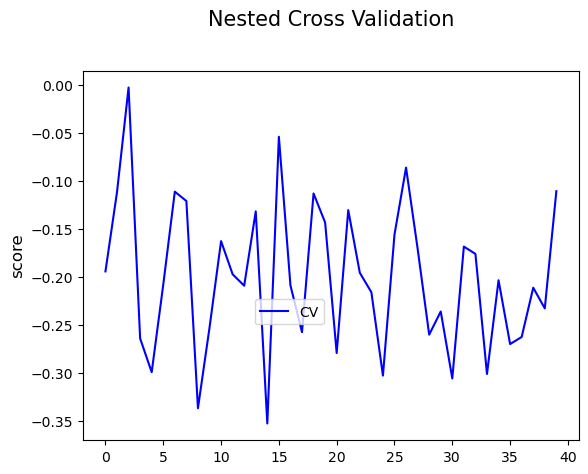

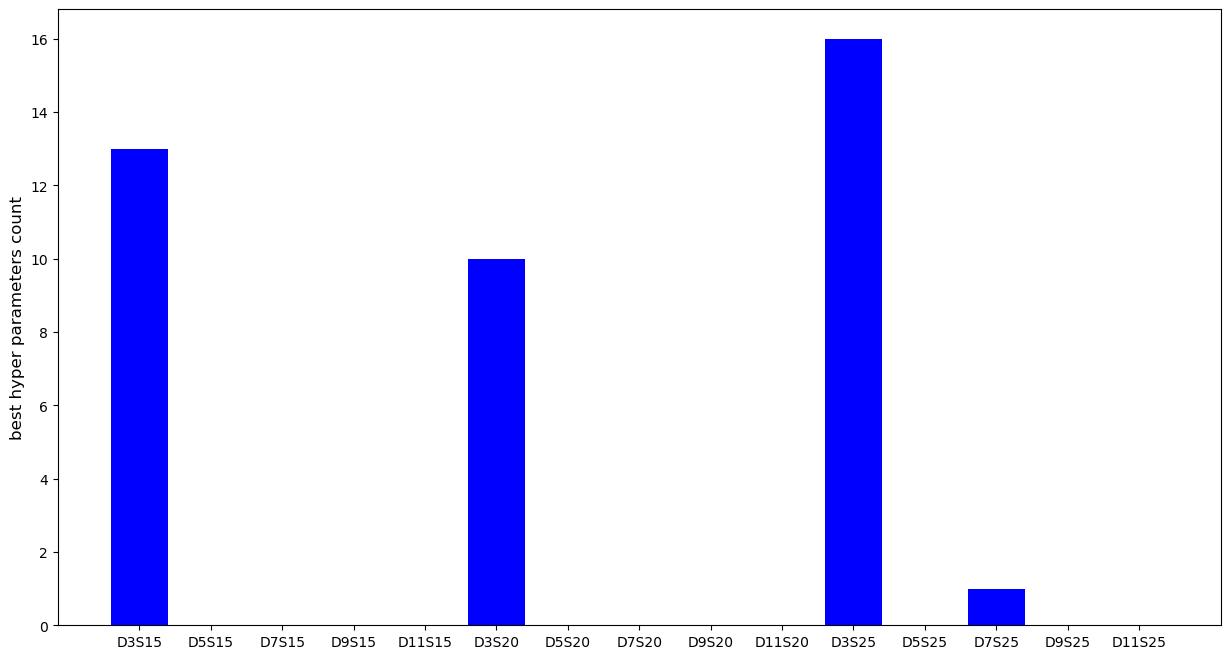

In [85]:
tree_dtr = tree.DecisionTreeRegressor()

X = features            
y = RFS            

NUM_TRIALS = 40
p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[15,20,25]}
scores = np.zeros(NUM_TRIALS)
params = []
for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    dtr = GridSearchCV(estimator=tree_dtr, param_grid=p_grid, cv=cv)
    dtr.fit(X,y)
    scores[i] = dtr.best_score_
    params.append(dtr.best_params_)
    best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
for i in params:
    best_hyper_params_count[int (i['min_samples_split']/5-3)][int((i['max_depth']-3)/2)] = params.count(i)
    
# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []


for j in range(15,30,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()



In [86]:

print(X.shape)

train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2,random_state=30)

print(train_X.shape,test_X.shape)
tree_dtr  =DecisionTreeRegressor(max_depth=3, min_samples_split =25)

tree_dtr.fit(train_X,train_Y)

predict_test_y = tree_dtr.predict(test_X)
 

from sklearn import metrics
print('MSE:{}'.format(metrics.mean_squared_error(predict_test_y,test_Y)))


(256, 68)
(204, 68) (52, 68)
MSE:780.4699763754821


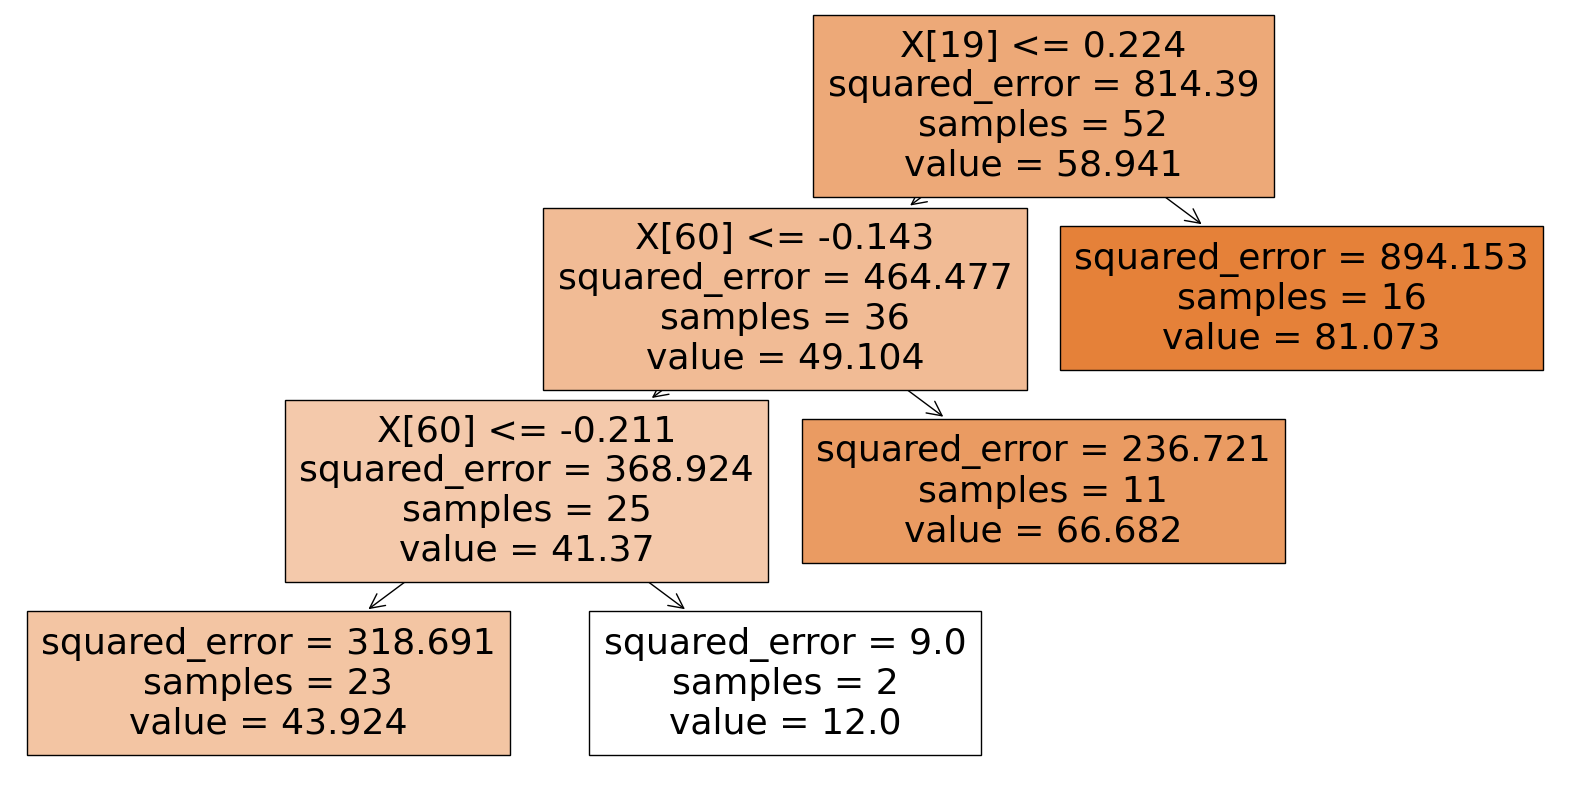

In [87]:
from sklearn.tree import plot_tree

plt.figure(figsize = (20,10))
plot_tree(tree_dtr.fit(test_X,test_Y), filled=True,max_depth=3)
plt.show()

### ANN

In [88]:
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

In [89]:

model_one_layer_1=keras.models.Sequential()
model_one_layer_1.add(keras.layers.Dense(32, input_shape=(all_df.iloc[:,1:].shape[1],), activation="relu"))
model_one_layer_1.add(keras.layers.Dense(1, activation='linear'))

model_one_layer_2=keras.models.Sequential()
model_one_layer_2.add(keras.layers.Dense(32, input_shape=(all_df.iloc[:,1:].shape[1],), activation="relu"))
model_one_layer_2.add(keras.layers.Dense(1, activation='linear'))

model_one_layer_3=keras.models.Sequential()
model_one_layer_3.add(keras.layers.Dense(32, input_shape=(all_df.iloc[:,1:].shape[1],), activation="relu"))
model_one_layer_3.add(keras.layers.Dense(1, activation='linear'))

model_one_layer_1.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.001),metrics=[keras.metrics.MeanSquaredError()])
model_one_layer_2.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.0001),metrics=[keras.metrics.MeanSquaredError()])
model_one_layer_3.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.00001),metrics=[keras.metrics.MeanSquaredError()])

In [90]:
from sklearn.model_selection import KFold
import os
import h5py

def train_ann(features, target, model, name):
    root_logdir = os.path.join(os.curdir, "my_logs")
    def get_run_logdir():
         import time
         run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
         return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    kf = KFold(n_splits=5)
    k=1
    
    all_score = []

    for train_index, test_index in kf.split(features):
        print("fold",k)
        # Split the data
        X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
        y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
        # training and validation
        model.fit(np.array(X_train), np.array(y_train), epochs=30, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[tensorboard_cb])

        #save the model of each fold
        model.save(os.path.join('./regression_models/fold_{}_{}.hdf5'.format(k, name)))

        # evaluate the accuracy of each fold
        scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
        k = k+1
    
        all_score.append(scores[1]*100)
    
    return all_score

ann = []
ann.append(train(features=all_df.iloc[:,1:], target=all_df['RelapseFreeSurvival (outcome)'], model=model_one_layer_1, name="model_one_layer_1"))
ann.append(train(features=all_df.iloc[:,1:], target=all_df['RelapseFreeSurvival (outcome)'], model=model_one_layer_2, name="model_one_layer_2"))
ann.append(train(features=all_df.iloc[:,1:], target=all_df['RelapseFreeSurvival (outcome)'], model=model_one_layer_3, name="model_one_layer_3"))

fold 1
Train on 204 samples, validate on 52 samples
Epoch 1/30
204/204 [==============================] - 0s 2ms/sample - loss: 2818.8170 - mean_squared_error: 2818.8171 - val_loss: 6553.2302 - val_mean_squared_error: 6553.2300
Epoch 2/30
204/204 [==============================] - 0s 48us/sample - loss: 1510.1721 - mean_squared_error: 1510.1722 - val_loss: 3443.3938 - val_mean_squared_error: 3443.3936
Epoch 3/30
204/204 [==============================] - 0s 38us/sample - loss: 640.3286 - mean_squared_error: 640.3287 - val_loss: 2984.1924 - val_mean_squared_error: 2984.1924
Epoch 4/30
204/204 [==============================] - 0s 48us/sample - loss: 546.0022 - mean_squared_error: 546.0022 - val_loss: 2666.7739 - val_mean_squared_error: 2666.7739
Epoch 5/30
204/204 [==============================] - 0s 53us/sample - loss: 469.0017 - mean_squared_error: 469.0016 - val_loss: 2558.9989 - val_mean_squared_error: 2558.9988
Epoch 6/30
204/204 [==============================] - 0s 53us/sample -

Train on 205 samples, validate on 51 samples
Epoch 1/30
205/205 [==============================] - 0s 48us/sample - loss: 742.7112 - mean_squared_error: 742.7113 - val_loss: 547.4760 - val_mean_squared_error: 547.4760
Epoch 2/30
205/205 [==============================] - 0s 38us/sample - loss: 723.1417 - mean_squared_error: 723.1418 - val_loss: 596.6858 - val_mean_squared_error: 596.6858
Epoch 3/30
205/205 [==============================] - 0s 57us/sample - loss: 705.3589 - mean_squared_error: 705.3588 - val_loss: 503.1364 - val_mean_squared_error: 503.1364
Epoch 4/30
205/205 [==============================] - 0s 52us/sample - loss: 685.9488 - mean_squared_error: 685.9489 - val_loss: 487.4788 - val_mean_squared_error: 487.4788
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 691.1383 - mean_squared_error: 691.1382 - val_loss: 563.9358 - val_mean_squared_error: 563.9358
Epoch 6/30
205/205 [==============================] - 0s 52us/sample - loss: 658.1119 - me

205/205 [==============================] - 0s 57us/sample - loss: 630.7489 - mean_squared_error: 630.7488 - val_loss: 329.9425 - val_mean_squared_error: 329.9426
Epoch 2/30
205/205 [==============================] - 0s 43us/sample - loss: 639.6632 - mean_squared_error: 639.6633 - val_loss: 457.7878 - val_mean_squared_error: 457.7878
Epoch 3/30
205/205 [==============================] - 0s 57us/sample - loss: 611.6810 - mean_squared_error: 611.6810 - val_loss: 349.3599 - val_mean_squared_error: 349.3599
Epoch 4/30
205/205 [==============================] - 0s 48us/sample - loss: 591.7415 - mean_squared_error: 591.7415 - val_loss: 333.7711 - val_mean_squared_error: 333.7711
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 615.5015 - mean_squared_error: 615.5014 - val_loss: 332.1889 - val_mean_squared_error: 332.1890
Epoch 6/30
205/205 [==============================] - 0s 52us/sample - loss: 588.7304 - mean_squared_error: 588.7303 - val_loss: 358.6574 - val_me

205/205 [==============================] - 0s 33us/sample - loss: 545.5505 - mean_squared_error: 545.5505 - val_loss: 297.1283 - val_mean_squared_error: 297.1283
Epoch 2/30
205/205 [==============================] - 0s 33us/sample - loss: 537.0314 - mean_squared_error: 537.0314 - val_loss: 364.9437 - val_mean_squared_error: 364.9437
Epoch 3/30
205/205 [==============================] - 0s 38us/sample - loss: 517.9050 - mean_squared_error: 517.9050 - val_loss: 543.9550 - val_mean_squared_error: 543.9550
Epoch 4/30
205/205 [==============================] - 0s 33us/sample - loss: 516.4907 - mean_squared_error: 516.4907 - val_loss: 501.7660 - val_mean_squared_error: 501.7660
Epoch 5/30
205/205 [==============================] - 0s 38us/sample - loss: 508.7445 - mean_squared_error: 508.7445 - val_loss: 384.0212 - val_mean_squared_error: 384.0211
Epoch 6/30
205/205 [==============================] - 0s 33us/sample - loss: 499.6991 - mean_squared_error: 499.6991 - val_loss: 287.7436 - val_me

205/205 [==============================] - 0s 48us/sample - loss: 476.9039 - mean_squared_error: 476.9038 - val_loss: 267.9701 - val_mean_squared_error: 267.9702
Epoch 2/30
205/205 [==============================] - 0s 71us/sample - loss: 462.7771 - mean_squared_error: 462.7771 - val_loss: 640.7034 - val_mean_squared_error: 640.7034
Epoch 3/30
205/205 [==============================] - 0s 76us/sample - loss: 483.5421 - mean_squared_error: 483.5422 - val_loss: 252.9861 - val_mean_squared_error: 252.9861
Epoch 4/30
205/205 [==============================] - 0s 90us/sample - loss: 436.7846 - mean_squared_error: 436.7846 - val_loss: 288.9599 - val_mean_squared_error: 288.9599
Epoch 5/30
205/205 [==============================] - 0s 90us/sample - loss: 457.4625 - mean_squared_error: 457.4625 - val_loss: 263.9869 - val_mean_squared_error: 263.9869
Epoch 6/30
205/205 [==============================] - 0s 76us/sample - loss: 453.7529 - mean_squared_error: 453.7529 - val_loss: 330.6535 - val_me

Epoch 1/30
204/204 [==============================] - 0s 2ms/sample - loss: 2978.2218 - mean_squared_error: 2978.2219 - val_loss: 7984.1424 - val_mean_squared_error: 7984.1426
Epoch 2/30
204/204 [==============================] - 0s 62us/sample - loss: 2904.8920 - mean_squared_error: 2904.8921 - val_loss: 7889.3400 - val_mean_squared_error: 7889.3403
Epoch 3/30
204/204 [==============================] - 0s 57us/sample - loss: 2827.5397 - mean_squared_error: 2827.5396 - val_loss: 7794.1562 - val_mean_squared_error: 7794.1562
Epoch 4/30
204/204 [==============================] - 0s 38us/sample - loss: 2740.2540 - mean_squared_error: 2740.2544 - val_loss: 7685.0465 - val_mean_squared_error: 7685.0469
Epoch 5/30
204/204 [==============================] - 0s 43us/sample - loss: 2643.1851 - mean_squared_error: 2643.1851 - val_loss: 7557.1905 - val_mean_squared_error: 7557.1904
Epoch 6/30
204/204 [==============================] - 0s 57us/sample - loss: 2531.7435 - mean_squared_error: 2531.74

205/205 [==============================] - 0s 67us/sample - loss: 1102.7040 - mean_squared_error: 1102.7040 - val_loss: 796.4261 - val_mean_squared_error: 796.4261
Epoch 2/30
205/205 [==============================] - 0s 52us/sample - loss: 1060.2602 - mean_squared_error: 1060.2603 - val_loss: 766.6605 - val_mean_squared_error: 766.6605
Epoch 3/30
205/205 [==============================] - 0s 38us/sample - loss: 1027.5323 - mean_squared_error: 1027.5323 - val_loss: 748.3966 - val_mean_squared_error: 748.3966
Epoch 4/30
205/205 [==============================] - 0s 52us/sample - loss: 1001.4521 - mean_squared_error: 1001.4521 - val_loss: 733.6529 - val_mean_squared_error: 733.6529
Epoch 5/30
205/205 [==============================] - 0s 43us/sample - loss: 980.7605 - mean_squared_error: 980.7605 - val_loss: 725.4783 - val_mean_squared_error: 725.4783
Epoch 6/30
205/205 [==============================] - 0s 33us/sample - loss: 962.3081 - mean_squared_error: 962.3081 - val_loss: 718.2235 

205/205 [==============================] - 0s 57us/sample - loss: 838.8645 - mean_squared_error: 838.8645 - val_loss: 358.6956 - val_mean_squared_error: 358.6956
Epoch 2/30
205/205 [==============================] - 0s 57us/sample - loss: 834.4703 - mean_squared_error: 834.4703 - val_loss: 349.5210 - val_mean_squared_error: 349.5210
Epoch 3/30
205/205 [==============================] - 0s 38us/sample - loss: 829.3053 - mean_squared_error: 829.3052 - val_loss: 359.9989 - val_mean_squared_error: 359.9988
Epoch 4/30
205/205 [==============================] - 0s 43us/sample - loss: 825.4928 - mean_squared_error: 825.4927 - val_loss: 354.2247 - val_mean_squared_error: 354.2247
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 819.4930 - mean_squared_error: 819.4930 - val_loss: 358.0354 - val_mean_squared_error: 358.0354
Epoch 6/30
205/205 [==============================] - 0s 33us/sample - loss: 816.9642 - mean_squared_error: 816.9642 - val_loss: 359.4044 - val_me

205/205 [==============================] - 0s 33us/sample - loss: 728.1508 - mean_squared_error: 728.1508 - val_loss: 546.9877 - val_mean_squared_error: 546.9877
Epoch 2/30
205/205 [==============================] - 0s 33us/sample - loss: 721.8640 - mean_squared_error: 721.8640 - val_loss: 561.9416 - val_mean_squared_error: 561.9416
Epoch 3/30
205/205 [==============================] - 0s 33us/sample - loss: 717.7062 - mean_squared_error: 717.7061 - val_loss: 574.1837 - val_mean_squared_error: 574.1838
Epoch 4/30
205/205 [==============================] - 0s 33us/sample - loss: 716.5563 - mean_squared_error: 716.5563 - val_loss: 596.6453 - val_mean_squared_error: 596.6453
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 713.2208 - mean_squared_error: 713.2208 - val_loss: 584.9394 - val_mean_squared_error: 584.9394
Epoch 6/30
205/205 [==============================] - 0s 38us/sample - loss: 711.1557 - mean_squared_error: 711.1557 - val_loss: 602.1390 - val_me

205/205 [==============================] - 0s 38us/sample - loss: 755.9259 - mean_squared_error: 755.9258 - val_loss: 307.2858 - val_mean_squared_error: 307.2858
Epoch 2/30
205/205 [==============================] - 0s 33us/sample - loss: 744.8878 - mean_squared_error: 744.8878 - val_loss: 323.4819 - val_mean_squared_error: 323.4819
Epoch 3/30
205/205 [==============================] - 0s 33us/sample - loss: 735.3079 - mean_squared_error: 735.3079 - val_loss: 331.9738 - val_mean_squared_error: 331.9738
Epoch 4/30
205/205 [==============================] - 0s 38us/sample - loss: 731.7739 - mean_squared_error: 731.7739 - val_loss: 338.3349 - val_mean_squared_error: 338.3349
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 728.1452 - mean_squared_error: 728.1452 - val_loss: 344.9924 - val_mean_squared_error: 344.9923
Epoch 6/30
205/205 [==============================] - 0s 38us/sample - loss: 727.5901 - mean_squared_error: 727.5901 - val_loss: 352.7702 - val_me

Epoch 1/30
204/204 [==============================] - 0s 2ms/sample - loss: 2918.6754 - mean_squared_error: 2918.6753 - val_loss: 7950.7332 - val_mean_squared_error: 7950.7334
Epoch 2/30
204/204 [==============================] - 0s 38us/sample - loss: 2911.5179 - mean_squared_error: 2911.5178 - val_loss: 7940.5408 - val_mean_squared_error: 7940.5410
Epoch 3/30
204/204 [==============================] - 0s 38us/sample - loss: 2904.2072 - mean_squared_error: 2904.2070 - val_loss: 7930.4275 - val_mean_squared_error: 7930.4277
Epoch 4/30
204/204 [==============================] - 0s 43us/sample - loss: 2896.9288 - mean_squared_error: 2896.9290 - val_loss: 7920.6552 - val_mean_squared_error: 7920.6553
Epoch 5/30
204/204 [==============================] - 0s 43us/sample - loss: 2889.6209 - mean_squared_error: 2889.6206 - val_loss: 7910.4724 - val_mean_squared_error: 7910.4722
Epoch 6/30
204/204 [==============================] - 0s 43us/sample - loss: 2882.2337 - mean_squared_error: 2882.23

205/205 [==============================] - 0s 33us/sample - loss: 3628.2831 - mean_squared_error: 3628.2832 - val_loss: 3817.8665 - val_mean_squared_error: 3817.8665
Epoch 2/30
205/205 [==============================] - 0s 62us/sample - loss: 3617.1377 - mean_squared_error: 3617.1377 - val_loss: 3804.1751 - val_mean_squared_error: 3804.1753
Epoch 3/30
205/205 [==============================] - 0s 52us/sample - loss: 3605.6725 - mean_squared_error: 3605.6726 - val_loss: 3789.9538 - val_mean_squared_error: 3789.9541
Epoch 4/30
205/205 [==============================] - 0s 38us/sample - loss: 3593.7434 - mean_squared_error: 3593.7437 - val_loss: 3775.2301 - val_mean_squared_error: 3775.2300
Epoch 5/30
205/205 [==============================] - 0s 38us/sample - loss: 3581.5321 - mean_squared_error: 3581.5320 - val_loss: 3760.7788 - val_mean_squared_error: 3760.7788
Epoch 6/30
205/205 [==============================] - 0s 43us/sample - loss: 3569.3577 - mean_squared_error: 3569.3577 - val_l

205/205 [==============================] - 0s 124us/sample - loss: 3570.1545 - mean_squared_error: 3570.1543 - val_loss: 1755.2379 - val_mean_squared_error: 1755.2379
Epoch 2/30
205/205 [==============================] - 0s 124us/sample - loss: 3545.8676 - mean_squared_error: 3545.8674 - val_loss: 1741.5030 - val_mean_squared_error: 1741.5031
Epoch 3/30
205/205 [==============================] - 0s 86us/sample - loss: 3520.5288 - mean_squared_error: 3520.5286 - val_loss: 1727.5665 - val_mean_squared_error: 1727.5665
Epoch 4/30
205/205 [==============================] - 0s 76us/sample - loss: 3495.8278 - mean_squared_error: 3495.8281 - val_loss: 1713.8622 - val_mean_squared_error: 1713.8623
Epoch 5/30
205/205 [==============================] - 0s 67us/sample - loss: 3470.5849 - mean_squared_error: 3470.5850 - val_loss: 1700.0601 - val_mean_squared_error: 1700.0601
Epoch 6/30
205/205 [==============================] - 0s 48us/sample - loss: 3445.0924 - mean_squared_error: 3445.0923 - val

205/205 [==============================] - 0s 33us/sample - loss: 2833.7013 - mean_squared_error: 2833.7012 - val_loss: 721.5568 - val_mean_squared_error: 721.5568
Epoch 2/30
205/205 [==============================] - 0s 52us/sample - loss: 2798.2974 - mean_squared_error: 2798.2976 - val_loss: 708.3281 - val_mean_squared_error: 708.3281
Epoch 3/30
205/205 [==============================] - 0s 62us/sample - loss: 2761.9760 - mean_squared_error: 2761.9763 - val_loss: 695.4231 - val_mean_squared_error: 695.4231
Epoch 4/30
205/205 [==============================] - 0s 48us/sample - loss: 2725.8669 - mean_squared_error: 2725.8667 - val_loss: 683.0788 - val_mean_squared_error: 683.0788
Epoch 5/30
205/205 [==============================] - 0s 48us/sample - loss: 2691.2481 - mean_squared_error: 2691.2483 - val_loss: 670.9843 - val_mean_squared_error: 670.9843
Epoch 6/30
205/205 [==============================] - 0s 67us/sample - loss: 2656.8045 - mean_squared_error: 2656.8047 - val_loss: 658.7

205/205 [==============================] - 0s 33us/sample - loss: 1681.2531 - mean_squared_error: 1681.2531 - val_loss: 1229.4664 - val_mean_squared_error: 1229.4664
Epoch 2/30
205/205 [==============================] - 0s 38us/sample - loss: 1663.9234 - mean_squared_error: 1663.9235 - val_loss: 1214.4525 - val_mean_squared_error: 1214.4525
Epoch 3/30
205/205 [==============================] - 0s 33us/sample - loss: 1646.7266 - mean_squared_error: 1646.7266 - val_loss: 1199.8638 - val_mean_squared_error: 1199.8638
Epoch 4/30
205/205 [==============================] - 0s 38us/sample - loss: 1630.7954 - mean_squared_error: 1630.7954 - val_loss: 1185.4423 - val_mean_squared_error: 1185.4423
Epoch 5/30
205/205 [==============================] - 0s 33us/sample - loss: 1614.2668 - mean_squared_error: 1614.2667 - val_loss: 1171.9386 - val_mean_squared_error: 1171.9386
Epoch 6/30
205/205 [==============================] - 0s 43us/sample - loss: 1599.0604 - mean_squared_error: 1599.0604 - val_l

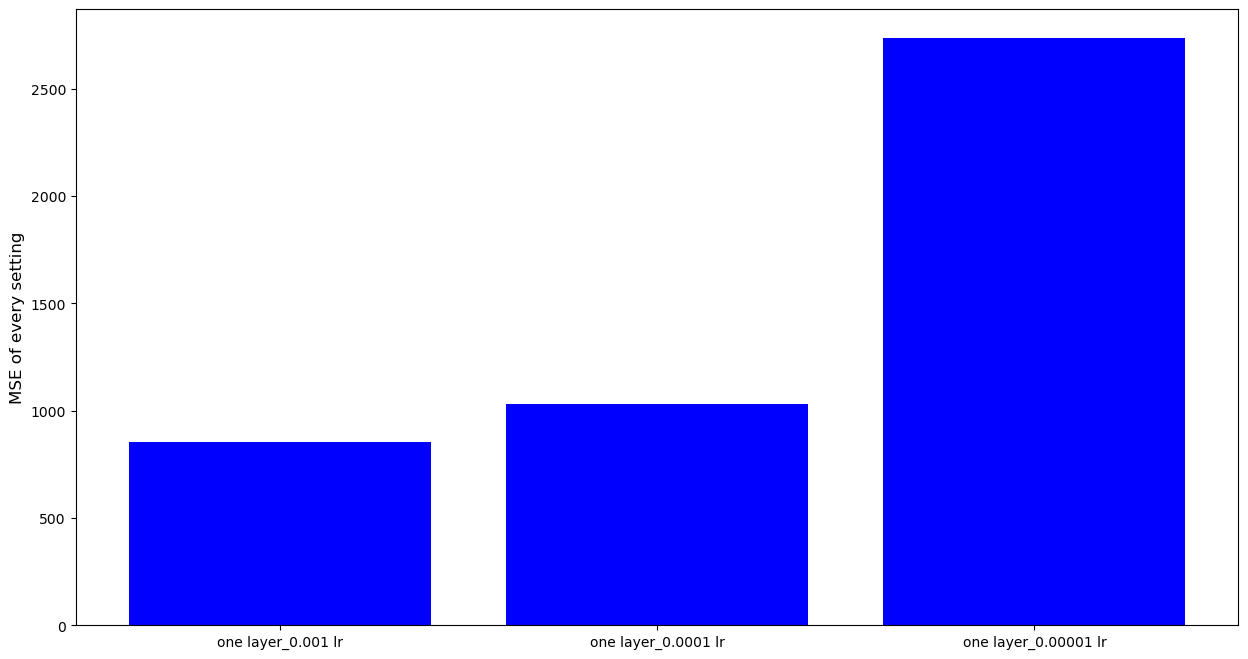

77/77 - 0s - loss: 394.9760 - mean_squared_error: 394.9760
Restored model best performance, MSE: 394.98


In [96]:
plt.figure(figsize = (15,8))

whole_list = []

lang = ['one layer_0.001 lr', 'one layer_0.0001 lr', 'one layer_0.00001 lr']

for elem in ann:
    whole_list.append(np.mean(elem))   

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("MSE of every setting", fontsize="12")

plt.show()

x_train, x_test, y_train, y_test = train_test_split(all_df.iloc[:,1:], all_df['RelapseFreeSurvival (outcome)'], test_size=0.3, random_state=1)

# model_one_layer_3.load_weights('./regression_models/fold_5_model_one_layer_3.hdf5')

y_pred=model_one_layer_1.predict(np.array(x_test))

loss, mse = model_one_layer_1.evaluate(np.array(x_test), np.array(y_test), verbose=2)
print("Restored model best performance, MSE: {:5.2f}".format(mse))